## Ejercicio 1: Cross validation

Fíjate cómo funciona un particionador de un dataset para cross validation

In [3]:
from sklearn.model_selection import KFold
import numpy as np
X = np.random.randint(10, size=(10,2))
for itr, its in KFold(n_splits=4).split(X):
    print "index train", itr, "index test", its
    print X[itr]
    print X[its]

index train [3 4 5 6 7 8 9] index test [0 1 2]
[[2 5]
 [5 2]
 [9 5]
 [3 3]
 [7 0]
 [7 6]
 [3 2]]
[[5 1]
 [2 2]
 [1 4]]
index train [0 1 2 6 7 8 9] index test [3 4 5]
[[5 1]
 [2 2]
 [1 4]
 [3 3]
 [7 0]
 [7 6]
 [3 2]]
[[2 5]
 [5 2]
 [9 5]]
index train [0 1 2 3 4 5 8 9] index test [6 7]
[[5 1]
 [2 2]
 [1 4]
 [2 5]
 [5 2]
 [9 5]
 [7 6]
 [3 2]]
[[3 3]
 [7 0]]
index train [0 1 2 3 4 5 6 7] index test [8 9]
[[5 1]
 [2 2]
 [1 4]
 [2 5]
 [5 2]
 [9 5]
 [3 3]
 [7 0]]
[[7 6]
 [3 2]]


completa la función siguiente para que dado un estimador, un dataset y un número de _folds_:
    
- itere sobre un `KFold` con los _folds_ especificados y en cada iteración:
    - entrene el estimador con la parte del dataset especificada por los índices de entrenamiento (el dataset de entrenamiento)
    - calcule el score con el dataset de entrenamiento
    - calcule el score con el dataset de test
- finalmente, la función tendrá que devolver la media y desviación estándar de los scores de entrenamiento y test obtenidos durante la iteración.

In [11]:
def crossval_estimator(estimator, X,y, n_folds=5):
    from sklearn.model_selection import KFold
    sctr, scts = [],[]
    for itr, its in  KFold(n_splits=n_folds).split(X):
        Xtr, ytr = X[itr], y[itr]
        Xts, yts = X[its], y[its]
        estimator.fit(Xtr,ytr)
        sctr.append(estimator.score(Xtr, ytr))
        scts.append(estimator.score(Xts, yts))
    return np.mean(sctr), np.std(sctr), np.mean(scts), np.std(scts)


Comprueba tu código, debería de darte una curva como esta en la que se ve el impacto de variar un parámetro del estimador

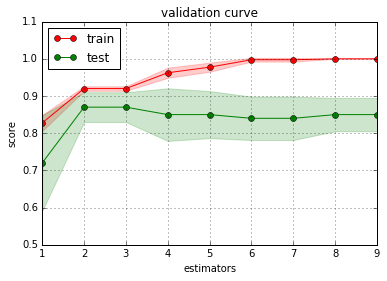

In [12]:
from IPython.display import Image
Image(filename='imgs/dt-depth.png')

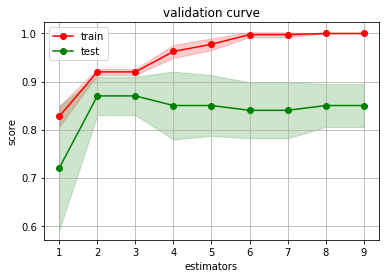

In [14]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
def crossval_estimators(estimators,X,y):
    meanstr, stdstr = [], []
    meansts, stdsts = [], []
    for estimator in estimators:
        mstr, sstr, msts, ssts = crossval_estimator(estimator, X, y, 5)
        meanstr.append(mstr)
        stdstr.append(sstr)
        meansts.append(msts)
        stdsts.append(ssts)

    return [np.array(i) for i in meanstr, meansts, stdstr, stdsts]

data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]
rngs = range(1,10,1)
estimators = [DecisionTreeClassifier(max_depth=i) for i in rngs]

def plot_cv_estimators(estimators, rngs, X,y):
    meanstr, meansts, stdstr, stdsts = crossval_estimators(estimators,X,y)

    plt.grid()
    plt.plot(rngs, meanstr, "o-", color="red", label="train")
    plt.fill_between(rngs, meanstr-stdstr, meanstr+stdstr, color="red", alpha=.2)

    plt.plot(rngs, meansts, "o-", color="green", label="test")
    plt.fill_between(rngs, meansts-stdsts, meansts+stdsts, color="green", alpha=.2)
    plt.xlabel("estimators")
    plt.ylabel("score")
    plt.legend(loc="best")
    plt.title("validation curve")
    
plot_cv_estimators(estimators, rngs, X,y)

## Ejercicio 2: Selección de modelos

Cuando queremos seleccionar o calibrar los parámetros de un modelo debemos de separar una parte del dataset para realizar el proceso de selección y otra parte para medir el desempeño del modelo que se seleccione. De esta manera, evitamos sesgos estadísticos en el desempeño final reportado.

Por tanto, dada una lista de estimadores y un datset:

- Dividimos el dataset en dos partes: una para hacer la selección de modelos (`Xsel`, `ysel`) y otra para medir el desempeño del modelo elegido (`Xtest`, `ytest`)

- Usamos un método de validación sobre `Xsel`/`ysel` sobre cada estimador y obtenemos un score de desempeño para cada uno de ellos. Esto es el **score de validación** de cada estimador. Observa que, dependiendo del método de validación, se crearán a su vez varias particiones de `Xsel`/`ysel` para entrenar y medir la capacidad de generalización de cada estimador.

- Seleccionamos el estimador que tenga el mejor score de validación.

- Entrenamos el estimador seleccionado con **TODOS LOS ELEMENTOS** de `Xsel`/`ysel`

- Medimos el desempeño del estimador con `Xtest`/`ytest`. Observa que esta es la **ÚNICA VEZ** que usamos estos datos.

Completa la función siguiente para que dado una lista de estimadores y las particiones `Xsel`/`ysel` y `Xtest`/`ytest`:

1. Realice un cross validation para cada estimador con `Xsel`/`ysel` y obtenga el promedio de desempeño de 5 folds. Usa la función [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) y la clase [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para el argumento `cv`. 
2. Determine cual es el estimador con mayor score promedio (*best_estimator*)
3. Entrene *best_estimator* con `Xsel`/`ysel`
4. Mida el score de *best_estimator* con `Xtest`/`ytest`
5. Devuelva:
   - *best_estimator*
   - el score  promedio de *best_estimator* en la fase de cross validation
   - el score de *best_estimator* con `Xtest`/`ytest`

In [18]:
def select_model(estimators, Xsel, ysel, Xtest, ytest):
    from sklearn.model_selection import cross_val_score, KFold
    means=[]
    for estimator in estimators:
        sc = cross_val_score(estimator, Xsel,ysel, cv=KFold(n_splits=5).split(Xsel))
        means.append(np.mean(sc))

    best = estimators[np.argmax(means)]
    best_crossval_score = np.max(means)
    best.fit(Xsel, ysel)
    return best, best_crossval_score, best.score(Xtest, ytest)

import urllib, inspect
src4 = urllib.quote_plus(inspect.getsource(select_model))

Comprueba tu código. La siguiente prueba muestrea  Xsel y Xtest y realiza el proceso de selección de modelo 100 veces. En promedio, el mejor `max_depth` debería de ser alrededor de 2.2, el score de cross validacion sobre 0.77 y el score de test sobre 0.74. Como cada vez se genera un dataset nuevo con `make_moons` el proceso es estocástico.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_moons

data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]

a = []
n=50
for i in range(100):
    X,y = make_moons(200, noise=.5)
    estimators = [DecisionTreeClassifier(max_depth=i) for i in range(1,5,1)]

    Xs, ys = X[:n], y[:n]
    Xt, yt = X[n:], y[n:]

    best, sc1, sc2 = select_model(estimators, Xs, ys, Xt, yt)
    a.append([sc1, sc2, best.max_depth])
print "scores    cv    test    max_depth"
print "promedios %.3f %.3f   %.3f"%tuple(np.mean(np.array(a), axis=0))
print "stds      %.3f %.3f   %.3f"%tuple(np.std(np.array(a), axis=0))


scores    cv    test    max_depth
promedios 0.767 0.738   2.150
stds      0.067 0.062   0.931


## Ejercicio 3: Resampling for learning curve

Fíjate cómo usamos una permutación para escoger aleatoriamente particiones de un vector. Observa que la permutación se usa para indexar los elementos del vector y los elementos escogidos son aleatorios y no se superponen.

In [25]:
v = np.random.randint(100, size=10)+100
print "Original vector", v
p = np.random.permutation(len(v))
print "Permutation", p
print "6 first elements of permutation", p[:6]
print "3 last elements of permutation ", p[-3:]
print "6 random elements (from the start)", v[p[:6]]
print "3 random elements (from the end)  ", v[p[-3:]]

Original vector [158 160 198 195 165 121 166 117 151 117]
Permutation [4 0 6 8 2 7 1 5 3 9]
6 first elements of permutation [4 0 6 8 2 7]
3 last elements of permutation  [5 3 9]
6 random elements (from the start) [165 158 166 151 198 117]
3 random elements (from the end)   [121 195 117]


Completa la función siguiente para que, dado un un estimador y un dataset `X/y`, repita `n_reps` veces el siguiente proceso, con `test_size` y `train_size`:

- Escoja aleatoriamente un conjunto de elementos de entrenamiento de `X/y` de según `train_size` (p.ej., 0.2 indica el 20% de los datos)
- Escoja aleatoriamente un conjunto de elementos de test de `X/y` de según `test_size` (p.ej., 0.2 indica el 20% de los datos). Estos datos **han de ser distintos** de los de entrenamiento. Puedes usar la técnica con permutaciones anterior. Asume que `test_size` + `train_size` es menor que 1.
- Entrene el estimador con los elementos de entrenamiento seleccionados
- Calcule el score con los datos de entrenamiento y con los de test

La función ha de devolver dos listas de longitud `n_reps`, una con los scores de entrenamiento obtenidos y otra con los scores de test. Observa que en **cada repetición** hay que muestrear **nuevos** conjuntos de entrenamiento y de test.

In [26]:
def lc_point(estimator, X, y, train_size, test_size, n_reps):

    if train_size + test_size > 1.:
        raise ValueError("train size and test size must add up to 1 or less")        
    tr_size = int(len(X)*train_size)
    ts_size = int(len(X)*test_size)
    sc_train, sc_test = [], []
    for i in range(n_reps):
        p = np.random.permutation(len(X))
                
        ptr, pts = p[:tr_size], p[-ts_size:]

        Xtr, ytr = X[ptr], y[ptr]
        Xts, yts = X[pts], y[pts]
        
        estimator.fit(Xtr, ytr)
        sc_train.append(estimator.score(Xtr, ytr))
        sc_test.append(estimator.score(Xts, yts))
    return sc_train, sc_test


Comprueba tu código. El promedio con 1000 repeticiones en train y test ha de ser 0.75 y 0.66 aprox.

In [28]:
from sklearn.datasets import make_circles
X,y = make_circles(300, noise=.1)
estimator = DecisionTreeClassifier(max_depth=3)
tr, ts = lc_point(estimator, X, y, .5,.5,1000)
np.mean(tr), np.mean(ts)

(0.7591133333333333, 0.67214)